In [1]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import KFold, cross_val_score
from sklearn.neighbors import KNeighborsClassifier
from sklearn.neighbors import KNeighborsRegressor
import glob
import numpy as np
import xgboost as xgb


In [2]:
cornbelters_files = glob.glob("../KCLData/*.csv")
other_files = glob.glob("../CornBeltersData/*.csv")

all_files = cornbelters_files + other_files

# Read and concatenate all CSVs into one DataFrame
stuff_plus = [pd.read_csv(f) for f in all_files]
df = pd.concat(stuff_plus, ignore_index=True)


In [164]:
dft = df[['PlayResult','RelSpeed','SpinRate','RelHeight','RelSide','Extension','InducedVertBreak', 'HorzBreak','VertApprAngle','ZoneSpeed']]

In [166]:
dft = dft.dropna()

In [167]:
dft['PlayResult'].unique()

array(['StrikeoutLooking', 'StrikeoutSwinging', 'Out', 'Single', 'Error',
       'Walk', 'Double', 'Triple', 'HomeRun', 'FieldersChoice',
       'Sacrifice', 'HItByPitch'], dtype=object)

In [168]:
map_data = {
    'Out': -.33,
    'Single': .46,
    'Double': .79,
    'StrikeoutLooking' : -.33,
    'StrikeoutSwinging' : -.33,
    'Error': 0,
    'Walk': .31,
    'Triple': 1.07,
    'HomeRun': 1.41,
    'FieldersChoice': 0,
    'Sacrifice': 0,
    'HItByPitch': .330,
    'HitByPitch': .33
}

dft['PlayResult'] = dft['PlayResult'].map(map_data)

In [169]:
dft.head()

PlayResult   RelSpeed     SpinRate  RelHeight   RelSide  Extension  \
6        -0.33  78.997127  2234.354700   5.643353  1.872089        6.0   
12       -0.33  86.577867  2090.806727   5.238482  2.212006        6.0   
16       -0.33  87.530392  1987.298234   5.566592  2.257963        6.0   
20       -0.33  80.916924  2165.574886   5.271006  2.011555        6.0   
28       -0.33  85.023046  1722.172115   5.837093  2.935782        6.0   

    InducedVertBreak  HorzBreak  VertApprAngle  ZoneSpeed  
6           6.484273  -2.228677      -7.636482  71.017599  
12         17.096434  15.031649      -3.825036  77.383626  
16         18.543534  12.824408      -5.872720  78.559184  
20         -1.006549   4.595121      -8.012842  72.678410  
28         14.298228  13.349795      -6.253648  76.292553

In [170]:
features = ['RelSpeed','SpinRate','RelHeight','RelSide','Extension','InducedVertBreak', 'HorzBreak','VertApprAngle','ZoneSpeed']

In [171]:
X = dft[features]
y = dft['PlayResult']


In [172]:
from sklearn.model_selection import train_test_split

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)


In [173]:
from scipy.stats import uniform, randint
from sklearn.model_selection import GridSearchCV, RandomizedSearchCV
from math import sqrt
# Define the XGBoost Regressor model
xgb_model_rand = xgb.XGBRegressor(objective='reg:squarederror',
                                  eval_metric='rmse',
                                  random_state=42)

param_distributions = {
    'n_estimators': randint(100, 1000),  
    'learning_rate': uniform(0.01, 0.29),  
    'max_depth': randint(3, 12),  
    'min_child_weight': randint(1, 10),  
    'subsample': uniform(0.5, 0.5),  
    'colsample_bytree': uniform(0.5, 0.5), 
    'gamma': uniform(0, 1),  
    'reg_alpha': uniform(0, 1), 
    'reg_lambda': uniform(0, 2),  
}

# Set up RandomizedSearchCV
# n_iter: Number of parameter settings that are sampled.
random_search = RandomizedSearchCV(
    estimator=xgb_model_rand,
    param_distributions=param_distributions,
    n_iter=100,  # Increased to try more combinations
    cv=KFold(n_splits=5, shuffle=True, random_state=42),
    scoring='neg_mean_squared_error',  # Keep for consistency
    verbose=2,
    random_state=42,
    n_jobs=-1,
    return_train_score=True  # Track training scores to diagnose overfitting
)

# Fit the RandomizedSearchCV object to your data
print("\nStarting RandomizedSearchCV...")
random_search.fit(X_train, y_train)

# Get the best parameters and best score
print(f"Best parameters found: {random_search.best_params_}")
print(f"Best cross-validation RMSE: {sqrt(-random_search.best_score_)}")


Starting RandomizedSearchCV...
Fitting 5 folds for each of 100 candidates, totalling 500 fits
Best parameters found: {'colsample_bytree': np.float64(0.8005575058716043), 'gamma': np.float64(0.7080725777960455), 'learning_rate': np.float64(0.01596950334578271), 'max_depth': 4, 'min_child_weight': 8, 'n_estimators': 591, 'reg_alpha': np.float64(0.9385527090157502), 'reg_lambda': np.float64(0.0015575316820286567), 'subsample': np.float64(0.9961057796456088)}
Best cross-validation RMSE: 0.4078801450045163


In [174]:
xgb_model = xgb.XGBRegressor(**random_search.best_params_,)
xgb_model.fit(X_train, y_train)


XGBRegressor(base_score=None, booster=None, callbacks=None,
             colsample_bylevel=None, colsample_bynode=None,
             colsample_bytree=np.float64(0.8005575058716043), device=None,
             early_stopping_rounds=None, enable_categorical=False,
             eval_metric=None, feature_types=None, feature_weights=None,
             gamma=np.float64(0.7080725777960455), grow_policy=None,
             importance_type=None, interaction_constraints=None,
             learning_rate=np.float64(0.01596950334578271), max_bin=None,
             max_cat_threshold=None, max_cat_to_onehot=None,
             max_delta_step=None, max_depth=4, max_leaves=None,
             min_child_weight=8, missing=nan, monotone_constraints=None,
             multi_strategy=None, n_estimators=591, n_jobs=None,
             num_parallel_tree=None, ...)

In [175]:
from sklearn.metrics import mean_squared_error
from math import sqrt

# Get the best model from RandomizedSearchCV
best_model = random_search.best_estimator_

# Make predictions on the test set
y_pred = best_model.predict(X_test)

# Calculate RMSE on the test set
test_rmse = sqrt(mean_squared_error(y_test, y_pred))

# Print the results
print(f"Test RMSE: {test_rmse}")

Test RMSE: 0.41916853910131296


In [176]:
from sklearn.metrics import r2_score

r2 = r2_score(y_test, y_pred)
print(f"Test R²: {r2}")

Test R²: 0.0024454842578015556


In [177]:
y_pred.mean()

np.float32(-0.017050523)

In [178]:
from itertools import product

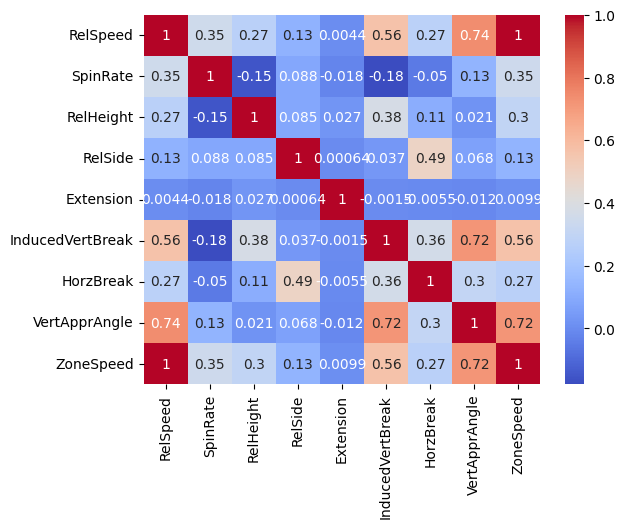

In [179]:
import seaborn as sns
sns.heatmap(X.corr(), annot=True, cmap='coolwarm')
plt.show()

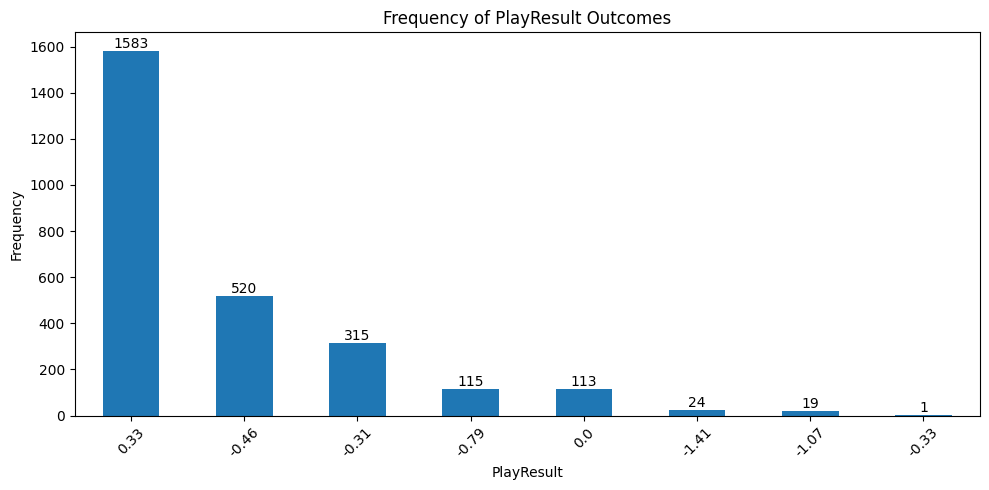

In [153]:
import matplotlib.pyplot as plt

plt.figure(figsize=(10,5))
ax = dft['PlayResult'].value_counts().plot(kind='bar')
plt.xlabel('PlayResult')
plt.ylabel('Frequency')
plt.title('Frequency of PlayResult Outcomes')
plt.xticks(rotation=45)
plt.tight_layout()

# Add counts above bars
for p in ax.patches:
    ax.annotate(f'{int(p.get_height())}', 
                (p.get_x() + p.get_width() / 2, p.get_height()), 
                ha='center', va='bottom', fontsize=10)

plt.show()

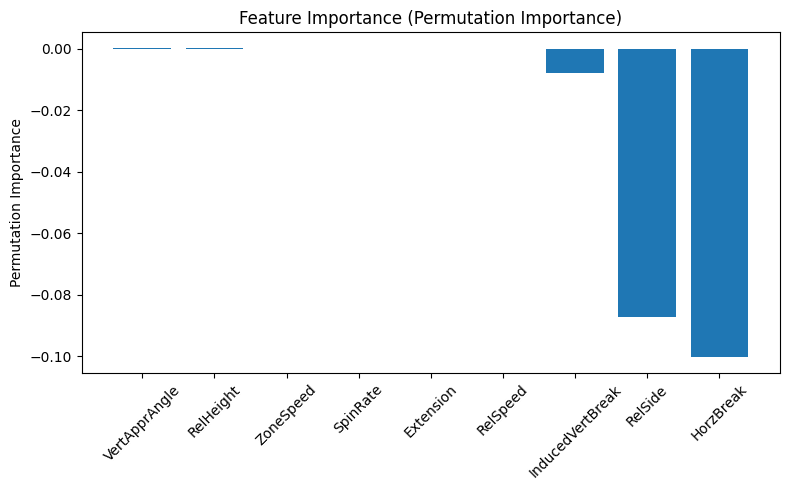

In [105]:
from sklearn.inspection import permutation_importance
import matplotlib.pyplot as plt

# Calculate permutation importance
result = permutation_importance(xgb_model, X, y, n_repeats=10, random_state=42)

# Get importances and sort
importances = result.importances_mean
indices = importances.argsort()[::-1]

# Plot
plt.figure(figsize=(8,5))
plt.bar(range(len(features)), importances[indices])
plt.xticks(range(len(features)), [features[i] for i in indices], rotation=45)
plt.ylabel("Permutation Importance")
plt.title("Feature Importance (Permutation Importance)")
plt.tight_layout()
plt.show()

In [155]:
from itertools import product

# Get mean values for the other features
mean_relspeed = X['RelSpeed'].mean()
mean_spinrate = X['SpinRate'].mean()
mean_relheight = X['RelHeight'].mean()
mean_relside = X['RelSide'].mean()
mean_extension = X['Extension'].mean()

# Create grid for InducedVertBreak and HorzBreak, fix other features at their mean
induced_vert_break = np.linspace(X['InducedVertBreak'].min(), X['InducedVertBreak'].max(), 100)
horz_break = np.linspace(X['HorzBreak'].min(), X['HorzBreak'].max(), 100)
combinations = list(product(induced_vert_break, horz_break))

sim_data = pd.DataFrame(combinations, columns=['InducedVertBreak', 'HorzBreak'])
sim_data['RelSpeed'] = mean_relspeed
sim_data['SpinRate'] = mean_spinrate
sim_data['RelHeight'] = mean_relheight
sim_data['RelSide'] = mean_relside
sim_data['Extension'] = mean_extension

# Reorder columns to match model input
sim_data = sim_data[['RelSpeed', 'SpinRate', 'RelHeight', 'RelSide', 'Extension', 'InducedVertBreak', 'HorzBreak']]

# Predict and scale
sim_data['PlayResult'] = xgb_model.predict(sim_data)
mean_playresult = sim_data['PlayResult'].mean()
sim_data['PlayResult_scaled'] = sim_data['PlayResult'] * (100 / mean_playresult)

# Hexbin plot for scaled predicted stuff+
plt.figure(figsize=(10, 6))
hb = plt.hexbin(
    sim_data['HorzBreak'],
    sim_data['InducedVertBreak'],
    C=sim_data['PlayResult_scaled'],
    gridsize=50,
    cmap='coolwarm',
    reduce_C_function=np.mean
)
plt.xlabel("HorzBreak")
plt.ylabel("InducedVertBreak")
plt.colorbar(hb, label="Predicted stuff+ (mean=100)")
plt.title("Predicted stuff+ Hexbin Plot (mean=100)\n(RelSpeed, SpinRate, RelHeight, RelSide, Extension fixed at mean)")
plt.tight_layout()

ValueError: feature_names mismatch: ['RelSpeed', 'SpinRate', 'RelHeight', 'RelSide', 'Extension', 'InducedVertBreak', 'HorzBreak', 'VertApprAngle', 'ZoneSpeed'] ['RelSpeed', 'SpinRate', 'RelHeight', 'RelSide', 'Extension', 'InducedVertBreak', 'HorzBreak']
expected VertApprAngle, ZoneSpeed in input data

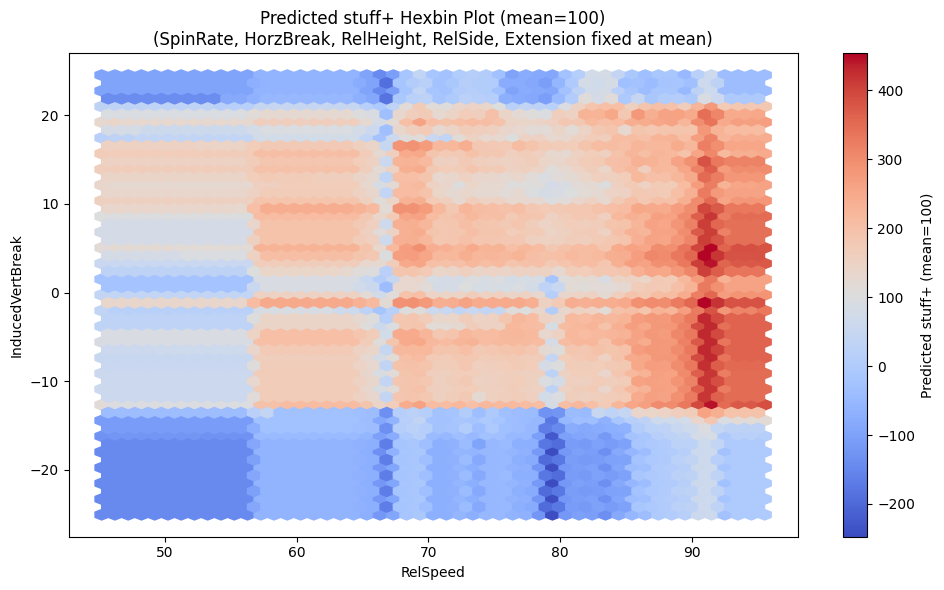

In [174]:
from itertools import product

# Get mean values for the other features
mean_spinrate = X['SpinRate'].mean()
mean_relheight = X['RelHeight'].mean()
mean_relside = X['RelSide'].mean()
mean_extension = X['Extension'].mean()
mean_horzbreak = X['HorzBreak'].mean()

# Create grid for InducedVertBreak and RelSpeed, fix other features at their mean
induced_vert_break = np.linspace(X['InducedVertBreak'].min(), X['InducedVertBreak'].max(), 100)
relspeed = np.linspace(X['RelSpeed'].min(), X['RelSpeed'].max(), 100)
combinations = list(product(induced_vert_break, relspeed))

sim_data = pd.DataFrame(combinations, columns=['InducedVertBreak', 'RelSpeed'])
sim_data['SpinRate'] = mean_spinrate
sim_data['RelHeight'] = mean_relheight
sim_data['RelSide'] = mean_relside
sim_data['Extension'] = mean_extension
sim_data['HorzBreak'] = mean_horzbreak

# Reorder columns to match model input
sim_data = sim_data[['RelSpeed', 'SpinRate', 'RelHeight', 'RelSide', 'Extension', 'InducedVertBreak', 'HorzBreak']]

# Predict and scale
sim_data['PlayResult'] = xgb_model.predict(sim_data)
mean_playresult = sim_data['PlayResult'].mean()
sim_data['PlayResult_scaled'] = sim_data['PlayResult'] * (100 / mean_playresult)

# Hexbin plot for scaled predicted stuff+
plt.figure(figsize=(10, 6))
hb = plt.hexbin(
    sim_data['RelSpeed'],
    sim_data['InducedVertBreak'],
    C=sim_data['PlayResult_scaled'],
    gridsize=50,
    cmap='coolwarm',
    reduce_C_function=np.mean
)
plt.xlabel("RelSpeed")
plt.ylabel("InducedVertBreak")
plt.colorbar(hb, label="Predicted stuff+ (mean=100)")
plt.title("Predicted stuff+ Hexbin Plot (mean=100)\n(SpinRate, HorzBreak, RelHeight, RelSide, Extension fixed at mean)")
plt.tight_layout()

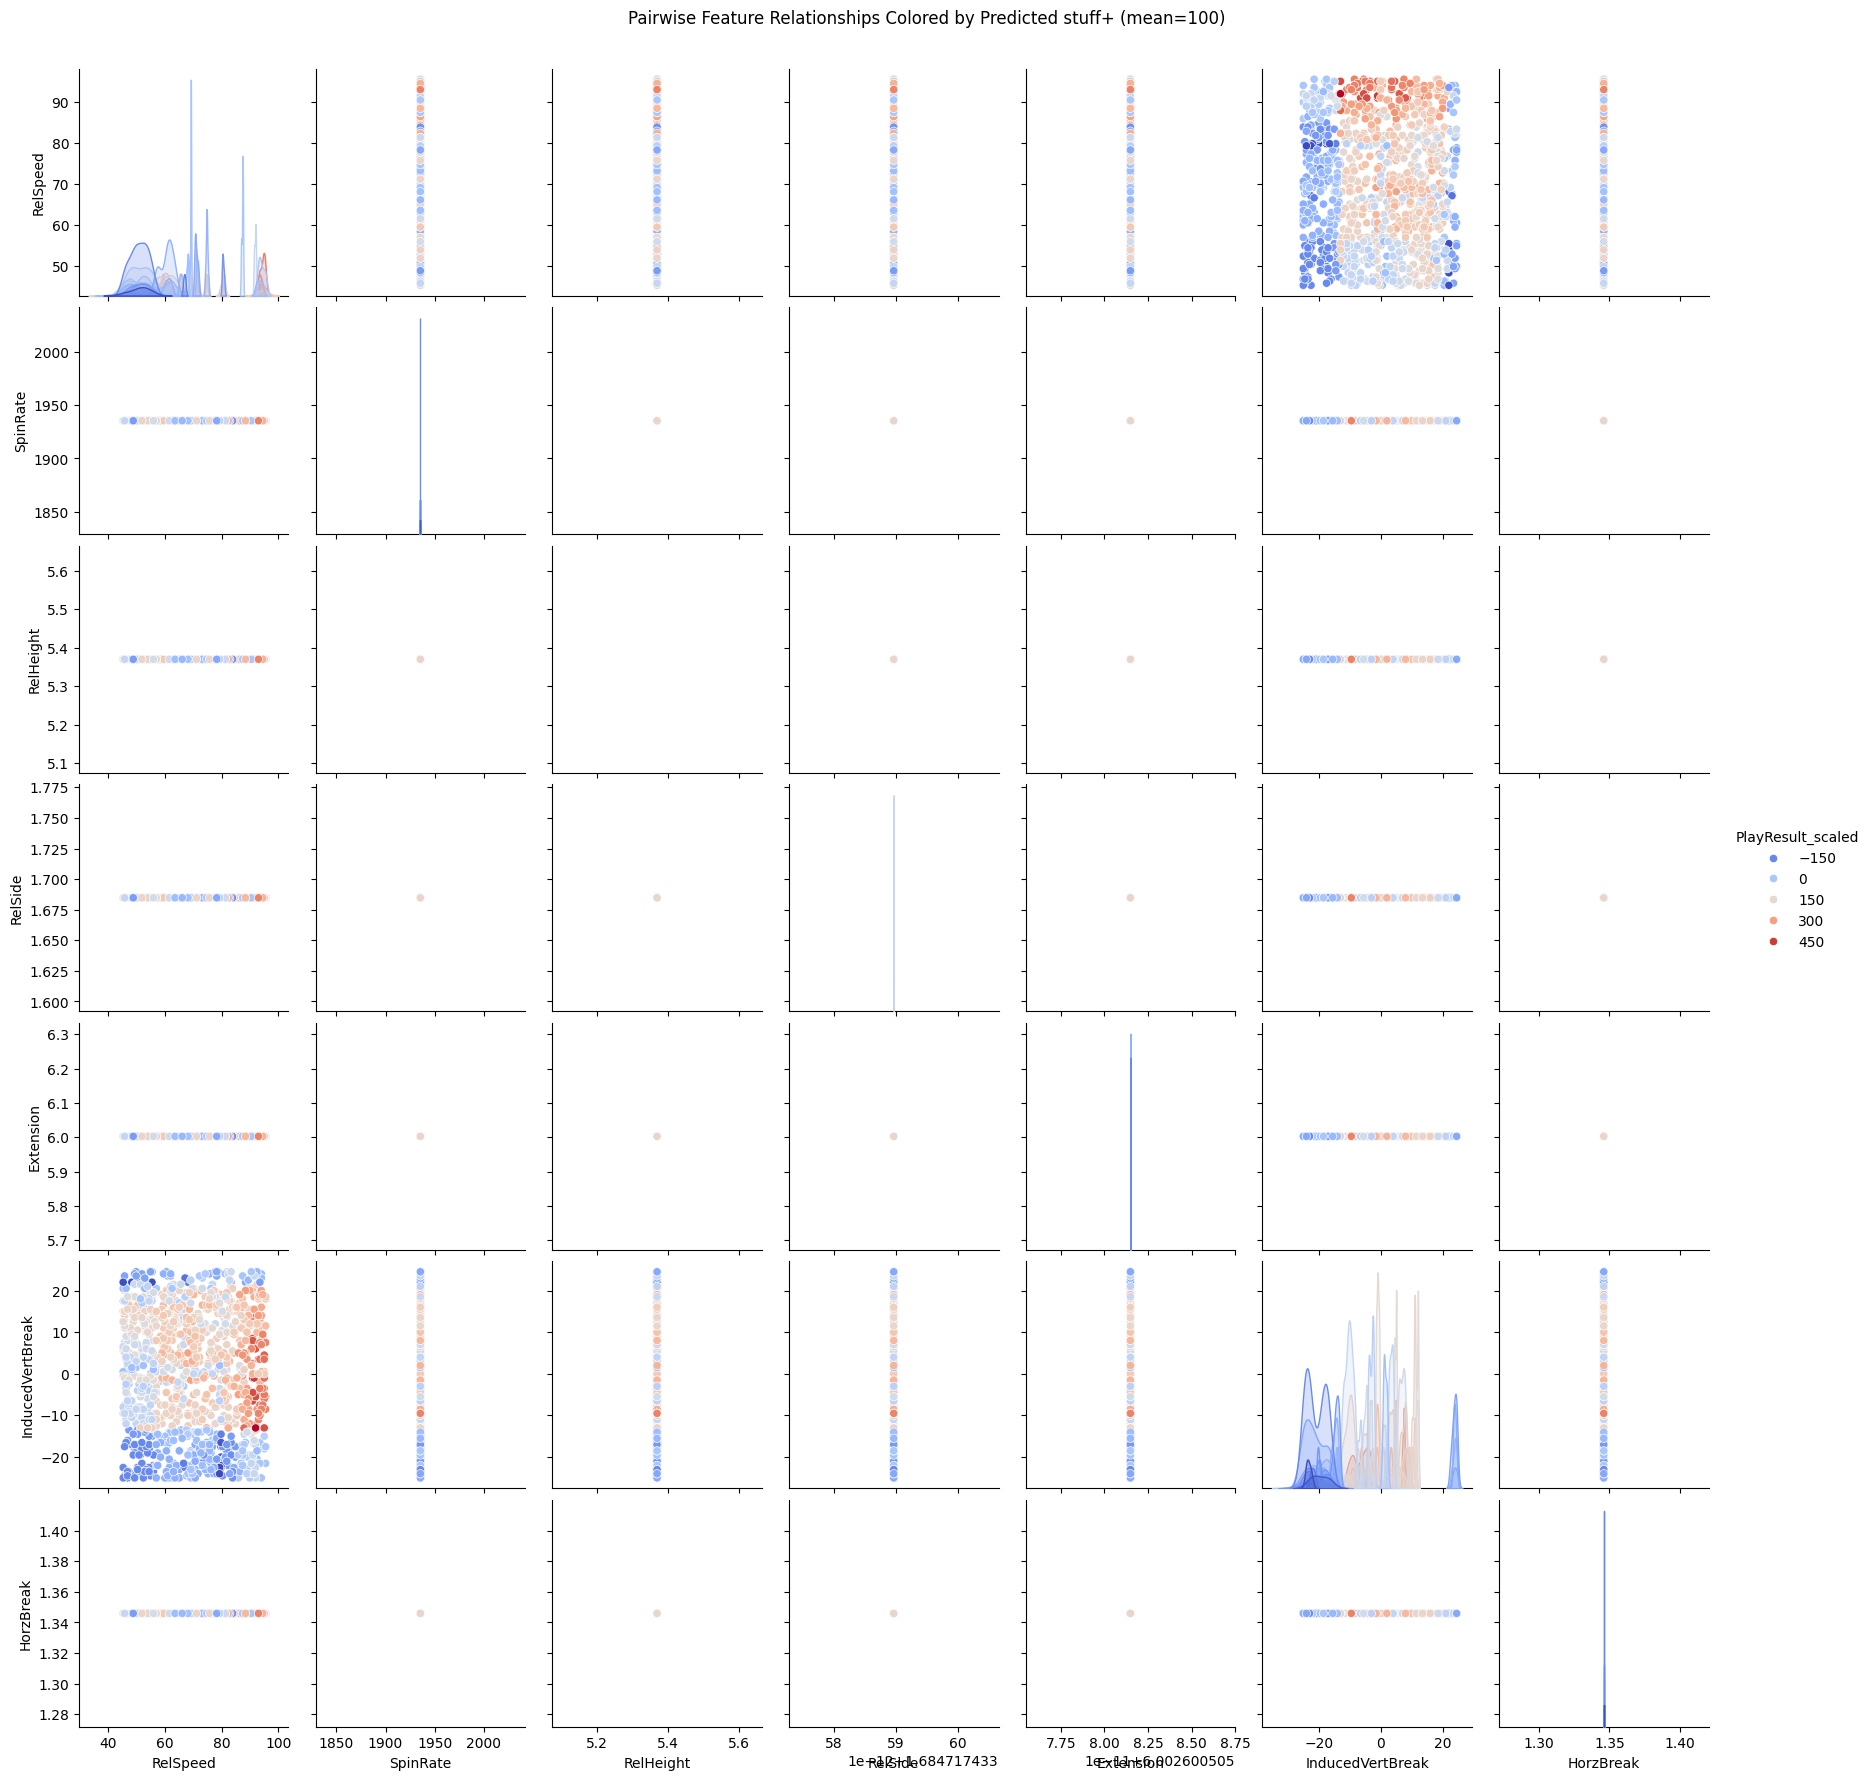

In [175]:
import seaborn as sns

# Sample a subset for visualization if your data is large
sampled = sim_data.sample(n=1000, random_state=42)

# Add the scaled prediction to the DataFrame if not already present
# sampled['PlayResult_scaled'] = sampled['PlayResult'] * (100 / sampled['PlayResult'].mean())

sns.pairplot(sampled, vars=['RelSpeed', 'SpinRate', 'RelHeight', 'RelSide', 'Extension', 'InducedVertBreak', 'HorzBreak'],
             hue='PlayResult_scaled', palette='coolwarm')
plt.suptitle("Pairwise Feature Relationships Colored by Predicted stuff+ (mean=100)", y=1.02)
plt.show()

In [180]:
def predict_stuff_plus(event):
    # Make sure all required features are present
    if all(f in event and not pd.isna(event[f]) for f in features):
        # Predict using the trained model
        pred = xgb_model.predict([[event[f] for f in features]])[0]
        # Scale so mean is 100 (use your training mean or pass as argument if needed)
        mean_playresult = y.mean()  # or use a fixed value if you want
        return pred * (100 / mean_playresult)
    else:
        return np.nan  # Not enough data to predict

In [183]:
y.mean()

np.float64(-0.014940520446096669)

In [159]:

cornbelters_files = glob.glob("../CornBeltersData/*.csv")
kcl_files = glob.glob("../kclData/*.csv")


# Read and concatenate all CSVs into one DataFrame
cornbelters  = [pd.read_csv(f) for f in cornbelters_files]
kcl = [pd.read_csv(f) for f in kcl_files]
kcl_df = pd.concat(kcl, ignore_index=True)
cornbelters_df = pd.concat(cornbelters, ignore_index=True)

In [181]:
# event should be a dict or Series with the 7 features
import warnings
warnings.filterwarnings("ignore")
kcl_df['stuff+'] = kcl_df.apply(predict_stuff_plus, axis = 1)
cornbelters_df['stuff+'] = cornbelters_df.apply(predict_stuff_plus, axis = 1)
kcl_df.to_csv("kcl_stuff+_data.csv", index=False)
cornbelters_df.to_csv("cornbelters_stuff+_data.csv", index=False)

AttributeError: 'FacetGrid' object has no attribute 'set_xlims'

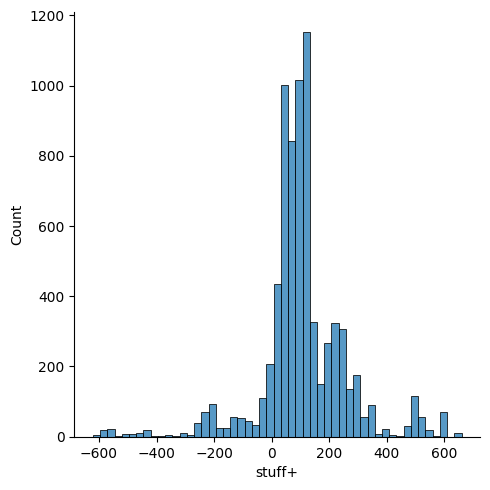

In [ ]:
import seaborn as sns
import matplotlib.pyplot as plt
g = sns.displot(kcl_df, x ='stuff+',binwidth = 25,loc=100)


In [46]:
import pandas as pd

# Load the CSV (replace with your actual file if needed)
df = pd.read_csv("cornbelters_stuff+_data.csv")

# Filter to only pitches with a valid pitcher name (optional, adjust as needed)
df = df[df['Pitcher'].notna()]

# Calculate mean stuff+ per pitcher
result = (
    df.groupby("Pitcher")
    .agg(
        Pitches=("stuff+", "count"),
        stuff_plus_mean=("stuff+", "mean")
    )
    .reset_index()
)

# Calculate percentile ranking
result["stuff+_percentile"] = result["stuff_plus_mean"].rank(pct=True)

# Sort by stuff+ descending
result = result.sort_values("stuff_plus_mean", ascending=False)

# Show the result
result.to_csv("cornbelters_stuff+_pitcher_ranking.csv", index=False)

In [47]:
import pandas as pd

# Load the CSV (replace with your actual file if needed)
df = pd.read_csv("kcl_stuff+_data.csv")

# Filter to only pitches with a valid pitcher name (optional, adjust as needed)
df = df[df['Pitcher'].notna()]

# Calculate mean stuff+ per pitcher
result = (
    df.groupby("Pitcher")
    .agg(
        Pitches=("stuff+", "count"),
        stuff_plus_mean=("stuff+", "mean")
    )
    .reset_index()
)

# Calculate percentile ranking
result["stuff+_percentile"] = result["stuff_plus_mean"].rank(pct=True)

# Sort by stuff+ descending
result = result.sort_values("stuff_plus_mean", ascending=False)

# Show the result
result.to_csv("kcl_stuff+_pitcher_ranking.csv", index=False)

In [135]:
import pickle

In [182]:
with open("stuff_plus_model.pkl", "wb") as f:
    pickle.dump(xgb_model, f)

In [25]:
y.mean()

np.float64(0.5845454545454546)